In [24]:
import sys
import os
from dotenv import load_dotenv
from enum import Enum
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import GoogleSerperAPIWrapper

load_dotenv(override=True)

True

In [47]:

llm = ChatOpenAI(model="gpt-4o-mini")
serper = GoogleSerperAPIWrapper()
tool_web_search = Tool(
    name="web_search",
    func=serper.run,
    description="Useful for when you need more information from the web about a query"
)
tools = [tool_web_search]
llm_with_tools = llm.bind_tools(tools)


In [13]:
class Phase(str, Enum):
    GENERATE = "generate"
    VALIDATE = "validate"
    AUDIT = "audit"
    COMPLETE = "complete"

In [17]:
class State(TypedDict):
    messages: Annotated[List, add_messages]
    user_problem: str
    current_phase: Phase
    iteration_count: int
    
    proposed_architecture: Dict[str, Any]
    architecture_components: Dict[str, Dict[str, Any]]

    validation_feedback: List[Dict[str, Any]]
    audit_feedback: List[Dict[str, Any]]

    active_agents: List[str]
    completed_agents: List[str]

    factual_errors_exist: bool
    design_flaws_exist: bool

    final_architecture: Optional[Dict[str, Any]]
    architecture_summary: Optional[str]
    

In [40]:
def architect_supervisor(state: State) -> State:
    """
    This function orchestrates the architecture generation process and coordinates the architect agents.
    """

    system_prompt = f"""
    You are a architect supervisor for AWS cloud architecture.
    Your role is to decompose the user's problem into smaller components on the basis of domain and assign them to different architect domain agents respectively.
    You will also be responsible for coordinating the work of these agents, ensuring that the overall architecture is aligned with the user's requirements and constraints.

    User Problem: {state["user_problem"]}
    Current Iteration: {state["iteration_count"]}

    Available feedback:
    - Validation feedback: {state["validation_feedback"]}
    - Audit feedback: {state["audit_feedback"]}

    Proposed Architecture: {state["proposed_architecture"]}

    Architecture Components: {state["architecture_components"]}

    Decompose the problem into tasks for:
    1. Compute Architect (EC2, Lambda, ECS, EKS, etc.)
    2. Network Architect (VPC, Subnets, ALB, CloudFront, Route 53, Security Groups, Route Tables, etc.)
    3. Storage Architect (S3, EBS, EFS, etc.)
    4. Database Architect (RDS, DynamoDB, ElastiCache, etc.)

    Provide clear instructions for each domain architect agent.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))
    new_state["active_agents"] = ["compute_architect", "network_architect", "storage_architect", "database_architect"]
    new_state["completed_agents"] = []

    return new_state

In [26]:
memory = MemorySaver()

In [41]:
graph_builder = StateGraph(State)

graph_builder.add_node("architect_supervisor", architect_supervisor)
graph_builder.add_edge(START, "architect_supervisor")
graph_builder.add_edge("architect_supervisor", END)

# graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()

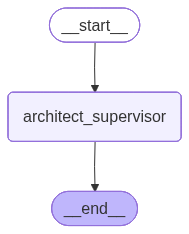

In [42]:
graph

In [45]:
def create_initial_state(user_problem: str) -> State:
    """
    Create the initial state for the architecture generation process.
    """
    return {
        "messages": [HumanMessage(content=user_problem)],
        "user_problem": user_problem,
        "current_phase": Phase.GENERATE,
        "iteration_count": 0,
        "proposed_architecture": {},
        "architecture_components": {},
        "validation_feedback": [],
        "audit_feedback": [],
        "active_agents": [],
        "completed_agents": [], 
        "factual_errors_exist": False,
        "design_flaws_exist": False,
        "final_architecture": None,
        "architecture_summary": None
    }

In [48]:
final_state = graph.invoke(create_initial_state("I need a scalable web application with a database and a storage system."))

In [50]:
final_state

{'messages': [HumanMessage(content='I need a scalable web application with a database and a storage system.', additional_kwargs={}, response_metadata={}, id='32da848f-3481-49da-b46f-6c1f9dc60614'),
  AIMessage(content="### Decomposed Tasks for Each Domain Architect Agent\n\n**1. Compute Architect**\n   - **Task**: Develop a strategy for deploying the web application reliably and at scale.\n   - **Instructions**: \n     - Assess the application’s workload characteristics to determine the best compute service (EC2, Lambda, ECS, EKS).\n     - If choosing EC2, define instance types, autoscaling groups, and load balancing requirements.\n     - If using containerized applications, outline the container orchestration choice (ECS vs EKS) along with the process of deploying and managing the application.\n     - For serverless applications, evaluate Lambda's function configurations and event sources.\n     - Ensure the architecture supports scalability, high availability, and fault tolerance.\n\

In [49]:
for message in final_state['messages']:
    message.pretty_print()

================================ Human Message =================================

I need a scalable web application with a database and a storage system.
================================== Ai Message ==================================

### Decomposed Tasks for Each Domain Architect Agent

**1. Compute Architect**
   - **Task**: Develop a strategy for deploying the web application reliably and at scale.
   - **Instructions**: 
     - Assess the application’s workload characteristics to determine the best compute service (EC2, Lambda, ECS, EKS).
     - If choosing EC2, define instance types, autoscaling groups, and load balancing requirements.
     - If using containerized applications, outline the container orchestration choice (ECS vs EKS) along with the process of deploying and managing the application.
     - For serverless applications, evaluate Lambda's function configurations and event sources.
     - Ensure the architecture supports scalability, high availability, and fault toler

In [57]:
def mark_agent_complete(state: State, agent_name: str) -> State:
    """
    Mark the specified agent as complete in the state.
    """
    new_state = state.copy()
    if agent_name not in new_state["active_agents"]:
        new_state["completed_agents"].append(agent_name)
            
    return new_state

In [53]:
def compute_architect(state: State) -> State:
    """
    This function implements the AWS compute architect agent.
    """

    system_prompt = f"""
    You are a compute architect for AWS cloud architecture.
    Your role is to design the compute infrastructure for the user's problem.

    Design compute components for: {state["user_problem"]}

    Consider:
    - EC2 instances (types, sizes, placement groups)
    - Lambda functions (serverless compute)
    - ECS/EKS (container orchestration)
    - Auto Scaling Groups 
    - Load Balancers 

    Use the web search only if you need more information about the compute pricing, features, or best practices.
    Provide detailed configuration recommendations.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_tools.invoke(messages)

    new_state = mark_agent_complete(state, "compute_architect")
    new_state["messages"].append(AIMessage(content=response.content))
    new_state["architecture_components"]["compute"] = {
        "recommendations": response.content,
        "agent": "compute_architect"
    }

    return new_state

In [ ]:
def agent_completion_router(state: State) -> State:
    """
    This function implements the agent completion routing based on the active_agents and completed_agents.
    """
    if state["current_phase"] == Phase.GENERATE:
        required_agents = ["compute_architect", "network_architect", "storage_architect", "database_architect"]
        if all(agent in state["completed_agents"] for agent in required_agents):
            return "move_to_validation"
        else:
            return "continue_generation"

In [55]:
def phase_router(state: State) -> State:
    """
    This function implements the phase routing based on the current_phase and quality gates.
    """
    if state["current_phase"] == Phase.GENERATE:
        return "architect_supervisor"
    elif state["current_phase"] == Phase.VALIDATE:
        return "validator_supervisor"
    elif state["current_phase"] == Phase.AUDIT:
        return "auditor_supervisor"
    elif state["current_phase"] == Phase.COMPLETE:
        return "final_presenter"
    else:
        return "architect_supervisor"

In [59]:
graph_builder = StateGraph(State)

graph_builder.add_node("architect_supervisor", architect_supervisor)
graph_builder.add_edge(START, "architect_supervisor")
graph_builder.add_conditional_edges("architect_supervisor", agent_completion_router, {"move_to_validation": "validator_supervisor", "continue_generation": "compute_architect"})
# graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()

ValueError: At 'architect_supervisor' node, 'agent_completion_router' branch found unknown target 'validator_supervisor'

In [ ]:
def validator_supervisor(state: State) -> State:
    """
    Supervisor that coordinates all validator agents.
    """

    system_prompt = f"""
    You are a validator supervisor for AWS cloud architecture.
    Your role is to coordinate the domain validators to validate the architecture components for factual correctness.
    """